In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, '..', 'data')
MODEL_PATH = os.path.join(BASE_DIR, '..', 'models', 'traffic_classifier.h5')

# Load model
model = load_model(MODEL_PATH)

In [ ]:
test_df = pd.read_csv(os.path.join(DATA_DIR, 'Test.csv'))
X_test = []
y_true = test_df['ClassId'].values

for img_path in test_df['Path'].values:
    img = cv2.imread(os.path.join(DATA_DIR, img_path))
    img = cv2.resize(img, (32, 32))
    X_test.append(img)

X_test = np.array(X_test) / 255.0
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


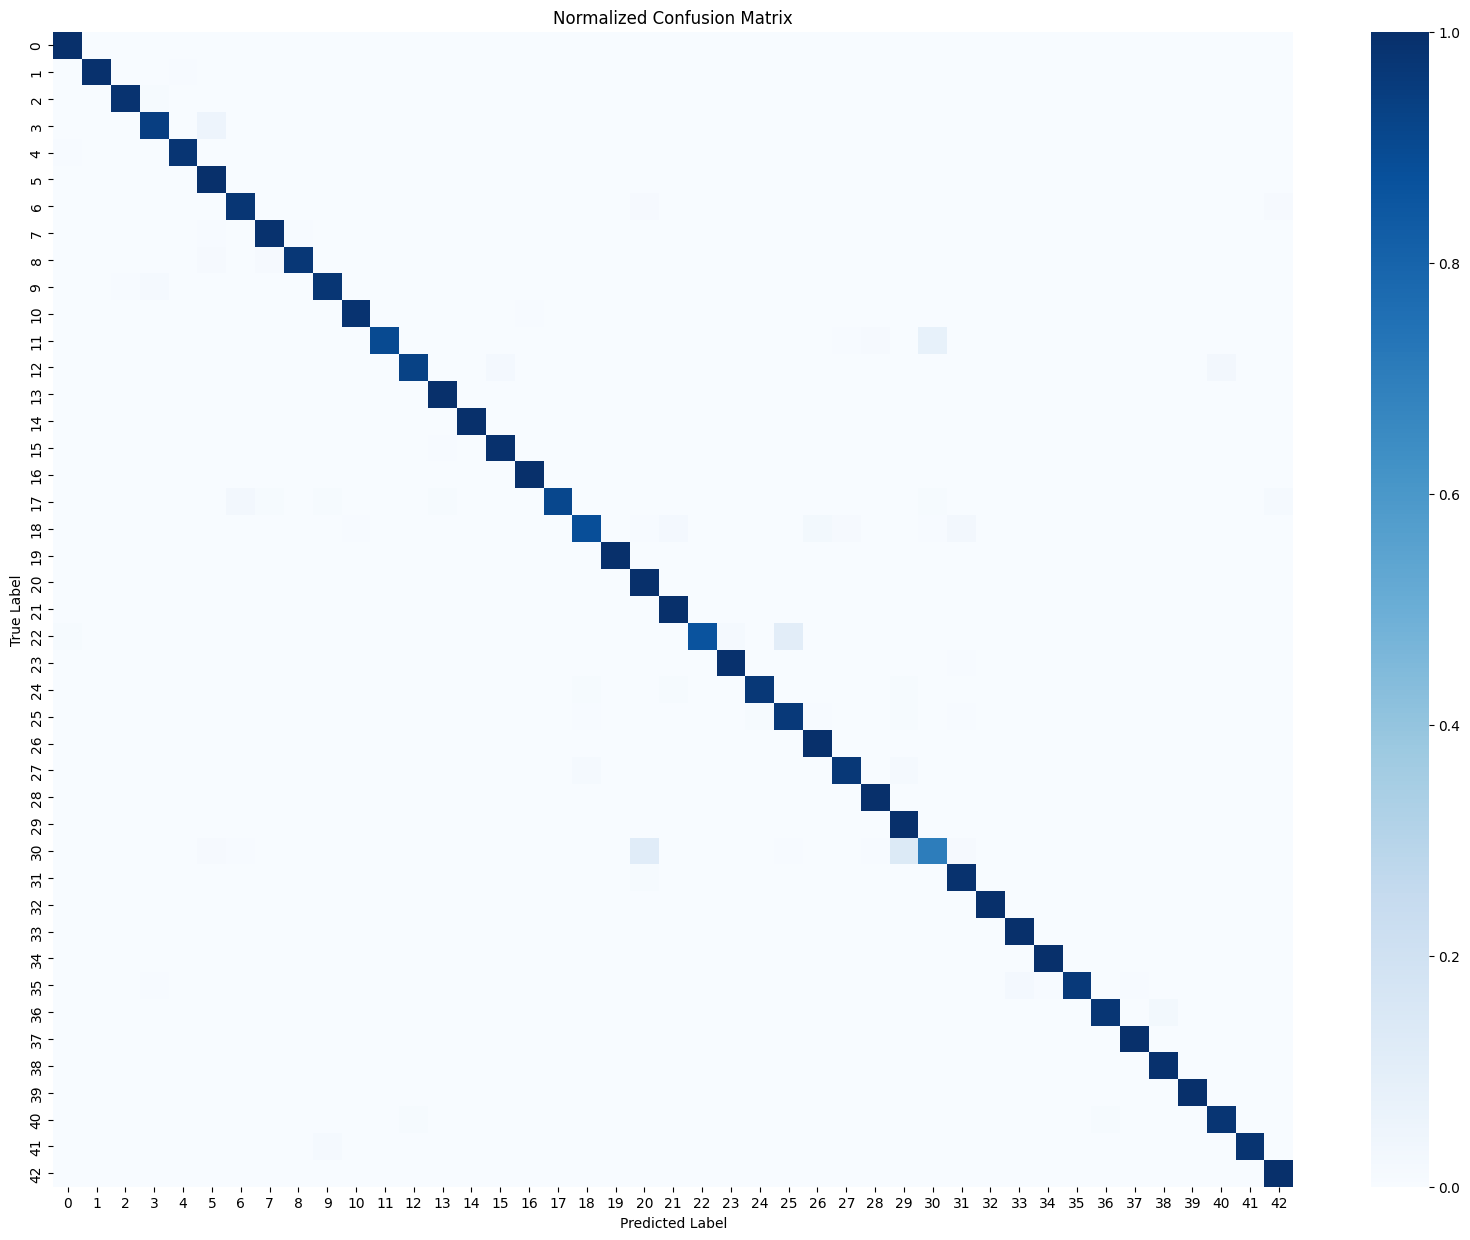

In [11]:
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(20, 15))
sns.heatmap(cm_norm, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()


In [ ]:
# Dictionary to name the classes
CLASSES = { 0:'Speed limit (20km/h)', 1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 9:'No passing', 
            10:'No passing veh over 3.5 tons', 11:'Right-of-way at intersection', 
            12:'Priority road', 13:'Yield', 14:'Stop', 15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 17:'No entry', 18:'General caution', 
            19:'Dangerous curve left', 20:'Dangerous curve right', 
            21:'Double curve', 22:'Bumpy road', 23:'Slippery road', 
            24:'Road narrows on the right', 25:'Road work', 26:'Traffic signals', 
            27:'Pedestrians', 28:'Children crossing', 29:'Bicycles crossing', 
            30:'Beware of ice/snow', 31:'Wild animals crossing', 
            32:'End speed + passing limits', 33:'Turn right ahead', 
            34:'Turn left ahead', 35:'Ahead only', 36:'Go straight or right', 
            37:'Go straight or left', 38:'Keep right', 39:'Keep left', 
            40:'Roundabout mandatory', 41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

# 1. Zero out the diagonal (ignore correct predictions)
np.fill_diagonal(cm, 0)

# 2. Find the top 5 most frequent errors
# Flatten matrix, sort, and get top 5 indices
pairs = np.unravel_index(np.argsort(cm, axis=None)[-5:], cm.shape)
true_classes = pairs[0][::-1]
pred_classes = pairs[1][::-1]

print("--- TOP 5 MOST CONFUSING PAIRS ---")
print(f"{'True Label':<35} | {'Predicted Label':<35} | {'Errors'}")
print("-" * 85)

for i in range(len(true_classes)):
    true_idx = true_classes[i]
    pred_idx = pred_classes[i]
    count = cm[true_idx, pred_idx]
    
    # Get names from dictionary
    true_name = CLASSES.get(true_idx, f"Class {true_idx}")
    pred_name = CLASSES.get(pred_idx, f"Class {pred_idx}")
    
    print(f"{true_name:<35} | {pred_name:<35} | {count}")

--- TOP 5 MOST CONFUSING PAIRS ---
True Label                          | Predicted Label                     | Errors
-------------------------------------------------------------------------------------
Right-of-way at intersection        | Beware of ice/snow                  | 33
Speed limit (60km/h)                | Speed limit (80km/h)                | 24
Beware of ice/snow                  | Bicycles crossing                   | 20
Priority road                       | Roundabout mandatory                | 19
Beware of ice/snow                  | Dangerous curve right               | 17


Total errors: 379


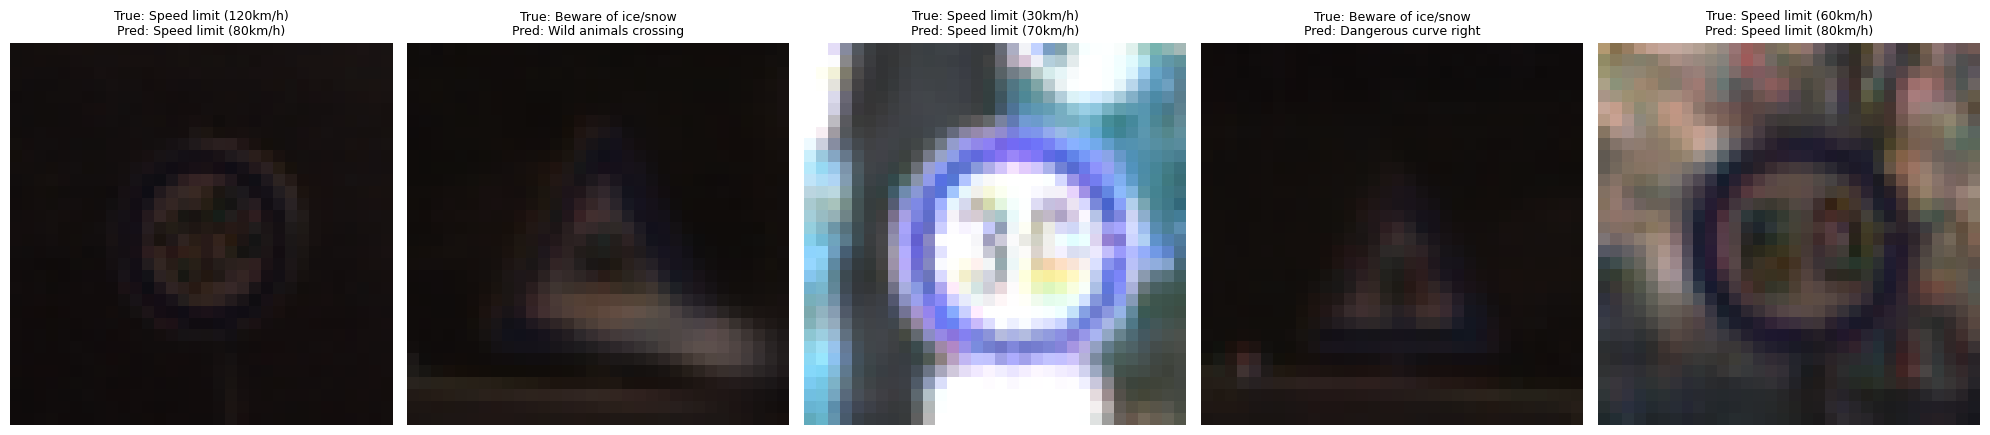

In [ ]:
# Find indices where prediction was wrong
errors = np.where(y_pred != y_true)[0]
print(f"Total errors: {len(errors)}")

# Show the first 5 errors
plt.figure(figsize=(20, 8))
for i, idx in enumerate(errors[:5]):
    plt.subplot(1, 5, i+1)
    
    # Look up the names using the CLASSES dict
    true_label = CLASSES.get(y_true[idx], "Unknown")
    pred_label = CLASSES.get(y_pred[idx], "Unknown")
    
    plt.imshow(X_test[idx])
    
    # Put names in the title (with a newline \n to keep it readable)
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

The model's errors are primarily due to **severe image degradation** (extreme blur and low resolution). In these cases, the signs are visually ambiguous even to a human observer, for example, in the middle image, it is impossible to distinguish between a '3' and a '7' based on the available pixels.

In [12]:
confidences = np.max(y_pred_probs, axis=1)
wrong = np.where(y_pred != y_true)[0]

high_conf_wrong = wrong[np.argsort(confidences[wrong])[-5:]]

for idx in high_conf_wrong:
    print(f"True: {CLASSES[y_true[idx]]}, "
          f"Pred: {CLASSES[y_pred[idx]]}, "
          f"Confidence: {confidences[idx]:.2f}")


True: Speed limit (60km/h), Pred: Speed limit (80km/h), Confidence: 1.00
True: No vehicles, Pred: Yield, Confidence: 1.00
True: Beware of ice/snow, Pred: Bicycles crossing, Confidence: 1.00
True: Beware of ice/snow, Pred: Bicycles crossing, Confidence: 1.00
True: Beware of ice/snow, Pred: Bicycles crossing, Confidence: 1.00
